In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [2]:
data = pd.read_csv("./RevRecortada.csv")

In [3]:
data["Text"].values[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [4]:
data.shape

(599, 10)

In [5]:
data = data.head(500)
data.shape

(500, 10)

Text(0.5, 0, 'Review Stars')

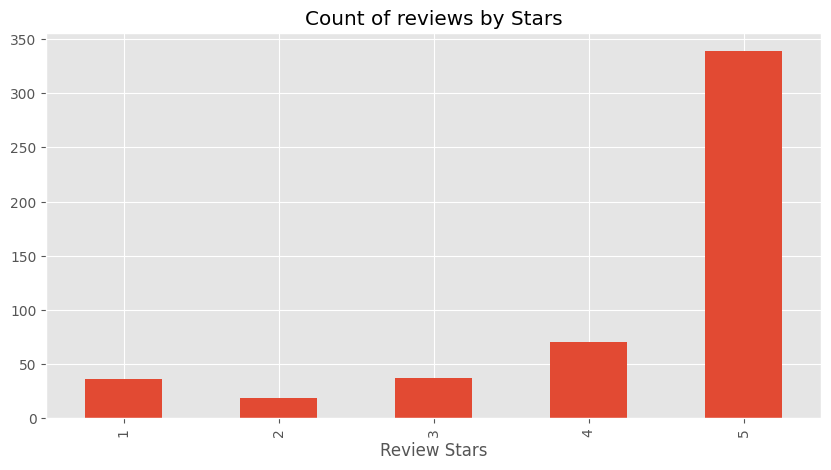

In [7]:
axis = data["Score"].value_counts().sort_index()\
      .plot(kind="bar",
          title="Count of reviews by Stars",
          figsize=(10,5))
axis.set_xlabel("Review Stars")

In [9]:
example = data["Text"][3]
print(example)

If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The flavor is very medicinal.


In [10]:
nltk.download('punkt')
nltk.download("averaged_perceptron_tagger")
nltk.download('maxent_ne_chunker')
nltk.download("words")
tokens = nltk.word_tokenize(example)
tokens[:5]

[nltk_data] Downloading package punkt to /home/jorge/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jorge/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/jorge/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/jorge/nltk_data...
[nltk_data]   Package words is already up-to-date!


['If', 'you', 'are', 'looking', 'for']

In [11]:
tagged = nltk.pos_tag(tokens)
tagged[:5]

[('If', 'IN'),
 ('you', 'PRP'),
 ('are', 'VBP'),
 ('looking', 'VBG'),
 ('for', 'IN')]

In [12]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  If/IN
  you/PRP
  are/VBP
  looking/VBG
  for/IN
  the/DT
  secret/JJ
  ingredient/NN
  in/IN
  Robitussin/NNP
  I/PRP
  believe/VBP
  I/PRP
  have/VBP
  found/VBN
  it/PRP
  ./.
  I/PRP
  got/VBD
  this/DT
  in/IN
  addition/NN
  to/TO
  the/DT
  (ORGANIZATION Root/NNP Beer/NNP)
  Extract/NNP
  I/PRP
  ordered/VBD
  (/(
  which/WDT
  was/VBD
  good/JJ
  )/)
  and/CC
  made/VBD
  some/DT
  cherry/JJ
  soda/NN
  ./.
  The/DT
  flavor/NN
  is/VBZ
  very/RB
  medicinal/JJ
  ./.)


*VADER*

In [13]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [14]:
a = sia.polarity_scores("I hate white people");
a

{'neg': 0.649, 'neu': 0.351, 'pos': 0.0, 'compound': -0.5719}

In [15]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [16]:
results = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    text = row["Text"]
    myid = row["Id"]
    results[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [17]:
#vaders = pd.DataFrame(results).T
#vaders = vaders.reset_index().rename(columns={"index": "Id"})
#vaders = vaders.merge(data, how="left")
#vaders.head()

In [18]:
#axis = sns.barplot(data=vaders, x="Score",y="compound")
#axis.set_title("Compund to stars")
#plt.show()

In [19]:
#fig, axs = plt.subplots(1,3,figsize=(15,5))
#sns.barplot(data=vaders, x="Score", y="pos", ax=axs[0])
#sns.barplot(data=vaders, x="Score", y="neu", ax=axs[1])
#sns.barplot(data=vaders, x="Score", y="neg", ax=axs[2])
#axs[0].set_title("positive")
#axs[1].set_title("neutral")
#axs[2].set_title("negative")
#plt.show()

In [20]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [21]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [22]:
tokens = tokenizer(example, return_tensors="pt")
output = model(**tokens)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
score = {
    "r_neg": scores[0],
    "r_neu": scores[1],
    "r_pos": scores[2]
}
score

{'r_neg': 0.0022951285, 'r_neu': 0.09021923, 'r_pos': 0.90748566}

In [23]:
def polarity_score_roberta(example):
    tokens = tokenizer(example, return_tensors="pt")
    output = model(**tokens)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    score = {
        "roberta_neg": scores[0],
        "roberta_neu": scores[1],
        "roberta_pos": scores[2]
    }
    return score

In [24]:
results = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    try:
        text = row["Text"]
        myid = row["Id"]

        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key,value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_score_roberta(text)

        dict = {**vader_result_rename, **roberta_result}
        results[myid] = dict
    except RuntimeError:
        print(f"Broke for id {myid}")

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [25]:
#results_df = pd.DataFrame(results).T
#results_df = results_df.reset_index().rename(columns={"index": "Id"})
#results_df = results_df.merge(data, how="left")
#results_df.head()

In [26]:
results_df.columns

NameError: name 'results_df' is not defined

In [ ]:
#sns.pairplot(data=results_df, vars=[ 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       #'roberta_neg', 'roberta_neu', 'roberta_pos'],
       #hue="Score", palette="tab10")
#plt.show()

In [ ]:
results_df.query("Score == 1").sort_values("roberta_pos", ascending=False)["Text"].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [ ]:
results_df.query("Score == 1").sort_values("vader_pos", ascending=False)["Text"].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [ ]:
results_df.query("Score == 5").sort_values("roberta_neg", ascending=False)["Text"].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [ ]:
results_df.query("Score == 5").sort_values("vader_neg", ascending=False)["Text"].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [ ]:
from transformers import pipeline

In [ ]:
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
